# Average Lunar Flux Brightness Simulation

In [4]:
# import various packages
import numpy as np
# import pandas as pd
from tqdm import tqdm
# import cupy as cp

## Area Calculation

Let's split up the moon into facets along lines of latitude and longitude 

In [2]:
def lunar_facets_areas(moon_radius):
    """
    Generation of facet areas over the surface of the Moon using latitude and longitude arrays.
    
    - Parameters:
        - moon_radius: Radius of the Moon in meters.
    
    - Returns: facet_areas: 2D array of facet areas (m²) corresponding to each latitude and longitude grid cell.
    """
    # Define ranges for phase, longitude, latitude, and declination
    # phase_array = np.arange(0, 360, dtype = np.int16) # angular positions of the sun overhead w.r.t latitude = 0, longitude = 0 position
    longitude_array= np.arange(-180, 181)#, dtype = np.int16)  # setting longitude range in degrees
    latitude_array = np.arange(-90, 91)#, dtype = np.int16)  # setting latitude range in degrees, (0,90 exclusive) I'm considering the centre point of each facet
    
    # Convert latitude and longitude arrays from degrees to radians
    latitudes = np.radians(latitude_array)
    longitudes = np.radians(longitude_array)
 
    # Compute the areas of the facets
    facet_areas = (moon_radius**2) * np.abs(-1* np.sin(latitudes[np.newaxis, 1:]) + np.sin(latitudes[np.newaxis, :-1])) * (longitudes[1:, np.newaxis] - longitudes[:-1, np.newaxis])
    
    return facet_areas

In [3]:
moon_radius_test = 1  # Radius of the Moon in meters
area_of_facets_test = lunar_facets_areas(moon_radius_test)
print('shape = ', area_of_facets_test.shape, 'area of surface = ' , np.sum(area_of_facets_test), ', Difference: 4pi - area_of_facets = ', 4 * np.pi - np.sum(area_of_facets_test))

shape =  (360, 180) area of surface =  12.566370614359172 , Difference: 4pi - area_of_facets =  0.0


In [4]:
area_of_facets_test.shape

(360, 180)

In [5]:
moon_radius = 1.737e6  # Radius of the Moon in meters
area_of_facets = lunar_facets_areas(moon_radius)

## Solar Zenith Angle for Phase cycle

In [6]:
def calculate_zenith_angle(phase):
    """
    Vectorized calculation of the zenith angle on each facet of lat, lon.
    - Parameters: 
        - phase: the current state of the lunar plase
    - Returns: Outputs a 3D array of zenith angles with shape (360, 180, 91)
    """
    deg_res = 0.5 # degree resolution, so that we are calculating the centre of the facets rather than zenith angles along edges
    longitude_edges = np.arange(-180 + deg_res, 180, 1)# setting longitude range in degrees
    latitude_edges = np.arange(-90 + deg_res, 90, 1)
    declination = 0
    # setting latitude range in degrees, (0,90 exclusive) I'm considering the centre point of each facet
    
    # Convert angles from degrees to radians for numpy trigonometric functions
    # phase_rad = np.radians(phase)[:, np.newaxis, np.newaxis]  # shape (360, 1, 1)
    phase_rad = np.radians(phase)

    longitude_rad = np.radians(longitude_edges)[:, np.newaxis]  # shape (360, 1)
    latitude_rad = np.radians(latitude_edges)[np.newaxis, :]  # shape (1, 180)
    declination_rad = np.radians(declination)

    # Calculate the zenith angle for all combinations of phase, lon, and lat
    zenith_angle_array = np.arccos(
        np.sin(declination_rad) * np.sin(latitude_rad)
        + np.cos(declination_rad) * np.cos(latitude_rad)
        * np.cos(longitude_rad + phase_rad)
    )

    return zenith_angle_array

## Calculate Flux for fascet centre

In [7]:
def flux_input_func(W_0, zenith_angle_array, albedo):
    """
    - Parameters:
        - W_0: energy flux W / m**2
        - zenith_angle_array: array of incident vector angle w.r.t sun
        - albedo: Lunar Albedo
    
    -Return: the flux input from the Sun. The time is indexed in degrees of phase, which allows isolating the values
    of latitude and longitude at that specific phase.
    """
    # Calculate the heat input based on the zenith angle
    W_t = W_0 * np.clip(np.cos(zenith_angle_array), 0, None) * (1 - albedo)

    # W/m^2 = W/m^2 * C * C
    # the clip returns a 0 for any values less than 0 resulting from an angle greater than 90 degrees
    # this way no negative heat is introduced.
    
    return W_t
               


In [8]:
W_0 = 1365.0 # Solar irradiance in W.m-2, the energy flux arriving from the Sun
albedo = 0.15 # the lunar albedo
phase = 0 # One degree in phase corresponds to 6700 seconds, phase ranges from [0,360) degrees
                # corresponds to [0, 2,405,300 seconds), [0, 668 hours), [0,27.8 days) phase_step inputs must be integers

zenith_angle_array_test = calculate_zenith_angle(phase)


flux_input_array_test = flux_input_func(W_0, 
                                   zenith_angle_array_test, 
                                   albedo)

In [9]:
# shape check
# flux_input_array.shape
# type(flux_input_array[0][0])

In [10]:
# verify that its matching the expected value
# print('function output', flux_input_array[180,:][0], 'manual calculation', (1-albedo) * 1365)
# sanity check for when longitude = 0, latitude = 0
# if time = 0 then subsolar position is theta = 0, longitude = 0

## Define Thermal Energy Tranfer Functions

In [11]:
def rate_of_change_surface_thermal_energy_func(flux_input_array, area_of_facets, T_0, T_1, sigma, BasCond, tau):
    """
    A function to calculate the rate of change of thermal energy at the surface 
    - Parameter: 
        - heat_input_array: a multi-dimensional array
        - area_of_facets: area of each surface m^2
        - T_0: temperatue at surface position [K]
        - T_1: temperature at depth below surface [K]
        - sigma: Stefan's constant 5.67e-8 (W/m²K⁴)
        - BasCond: Basalt conductivity in (W/m/K)
        - tau: 0.01, is the thickness of the slice [m]
        
    -Return: A scalar value of the rate of change of thermal energy of the surface layer
    """
    # previous version
    # dQ0_dt = heat_input_array - sigma * T_0**4 + (T_1 - T_0) / R 

    # Ken's Version
    # LTK[j] =  LTK[j] + (A*(I - sigma*LTK[j]**4) + (LTK[j+1] - LTK[j])*beta)*delta_t/gamma        

    dQ0_dt = (area_of_facets * (flux_input_array - sigma * T_0**4)) + ((T_1 - T_0) * BasCond * (area_of_facets/tau))
    # W = (m^2 * ( W/m^2 - W/m^2/K^4 * K^4)) + ((K - K) * W/m/K * (m^2/m))
    
    return dQ0_dt

In [12]:
def rate_of_change_intermediate_thermal_energy_func(T_np1, T_n, T_nm1, BasCond, area_of_facets, tau):
    """
    A function to calculate the rate of change of thermal energy in the intermediate layers
    - Parameter: 
        - T_nm1: Previous Layer (T_n-1)
        - T_np1: Next Layer (T_n+1)
        - T_n: Layer being evaluated
        - tau: dz or thickness of layer [m]
        - BasCond: Basalt conductivity in W/m/K
        - area_of_facets: surface area [m^2]
        
        
    -Return: A scalar value of the rate of change of thermal energy of the surface layer applied to each element for which there 
    """
    # previous version
    # dQn_dt = ((T_np1 - T_n) / R) + ((T_nm1 - T_n) / R)

    # Ken's Version from moon_temp_model
    # LTK[j] = LTK[j] + ((LTK[j+1]-LTK[j])*beta + (LTK[j-1] - LTK[j])*beta)*delta_t/gamma 

    # 
    # dQn_dt = (((T_np1 - T_n) + (T_nm1 - T_n)) * (BasCond * area_of_facets/tau))
    # W = (((K - K) + (K - K)) * (W/m/K * m^2/m)

    # faster version
    dQn_dt = (((T_np1 + T_nm1) - (2 * T_n)) * (BasCond * area_of_facets/tau))
    # W = (((K + K) - (2 * K) * ( W/m/K * m^2/m)
    
    return dQn_dt

In [13]:
def rate_of_change_final_thermal_energy_func(T_const, T_f, T_nm1, BasCond, area_of_facets, tau):
    """
    The rate of change of thermal energy at the final depth 
    - Parameter: 
        - T_nm1: Previous Layer (T_n-1) [K]
        - T_const: The temperature below the layers being evaluated, a constant value [K]
        - T_f: The final layer being evaluated that between the previous layer and the T_constant layer [K]
        - BasCond: Basalt conductivity in W/m/K
        - area_of_facets: area of the evalulated facet in m^2
        - 
    -Return: A scalar value of the rate of change of thermal energy of the surface layer applied to each element for which there 

    """
    dQf_dt = (((T_const + T_nm1) - (2 * T_f)) * (BasCond * area_of_facets/tau))

    # W = (((K + K) - (2 * K) * ( W/m/K * m^2/m)
    
    return dQf_dt

In [14]:
# New Version
def thermal_capacitance(BasCap, area, tau, density):
    """
    Calculation of the thermal capacitance
    - Parameters:
        - BasCap: Basalt thermal capacity in J Kg-1.K-1 
        - area: is the area of the slice of material, passed as an array of area's
        - tau: 0.01, is the thickness of the slice [m]
        - density: 1500.0, Lunar regolith density in Kg.m-3
    - Return: gamma, thermal capacitance [J/K]
    """
    gamma = BasCap * area * tau * density # J/K = J/kg/K * m^2 * m * kg/ m^3
    
    return gamma

## Develop the Heat Transfer Model

In [15]:
def heat_transfer_model_func(heat_transfer_array, W_0, albedo, T_const, BasCap, area_of_facets, tau, rho, delta_t, model_run_time):
    """
    Heat transfer model to update temperature in each layer over time.

    Parameters:
    - heat_transfer_array: 3D NumPy array representing Temperature of all lunar soil layers [K]
    - W_0: Energy flux arriving from the Sun [W/m^2]
    - albedo: Albedo (reflectivity) of the surface [unitless]
    - T_const: Constant temperature for the final boundary condition [K]
    - BasCap: Basalt thermal capacity in J Kg-1.K-1
    - area_of_facets: area of the evalulated facet [m^2]
    - tau: tau: the thickness of the soil depth [m]
    - delta_t: Time step for updating temperatures
    - model_run_time: Total simulation time in seconds

    Returns:
    - heat_transfer_array: 3D numpy array with updated temperatures for each layer over elapsing run time.
    """
       # calculate the area of lunar facets along lines of latitude/longitude
    area_of_facets = lunar_facets_areas(moon_radius)
    
    # Step 1: Initialize Thermal Capacitance
    gamma = thermal_capacitance(BasCap, area_of_facets, tau, rho)#.astype(np.float64)

    phase = 0
    
    for second in tqdm(range(0, model_run_time, delta_t)): # range(start,stop,step)
    # for second in range(0, model_run_time, delta_t): # range(start,stop,step) No tqdm package installed in this env


        # Step 2: Update the surface layer (T_0)
        T_0 = heat_transfer_array[:,:,0] # (longitude, latitude, depth)
        T_1 = heat_transfer_array[:,:,1]

        zenith_angle_array = calculate_zenith_angle(phase)
        W_t = flux_input_func(W_0, zenith_angle_array, albedo) 

        dQ0_dt = rate_of_change_surface_thermal_energy_func(W_t, area_of_facets, T_0, T_1, sigma, BasCond, tau)
        T_0 += (dQ0_dt * delta_t) / gamma

        # Step 3: Update intermediate layers
        T_n = heat_transfer_array[:,:,1:-1]  # All intermediate layers

        T_np1 = heat_transfer_array[:,:,2:]  # Next layer in each direction

        T_nm1 = heat_transfer_array[:,:,:-2]  # Previous layer in each direction
        dQn_dt = rate_of_change_intermediate_thermal_energy_func(T_np1, T_n, T_nm1, BasCond, area_of_facets[:,:,np.newaxis], tau)
        
        T_n += (dQn_dt * delta_t) / gamma[:,:,np.newaxis]

        # Step 4: Update the final layer (T_f)
        T_f = heat_transfer_array[:,:,-1]
        T_fm1 = heat_transfer_array[:,:,-2]
        T_nm1 = T_nm1[:,:,-1]
        dQf_dt = rate_of_change_final_thermal_energy_func(T_const, T_f, T_nm1, BasCond, area_of_facets, tau)
        T_f += (dQf_dt * delta_t) / gamma

        # Step 5: Update the heat transfer array with new temperatures
        heat_transfer_array[:,:,0] = T_0
        heat_transfer_array[:,:,1:-1] = T_n
        heat_transfer_array[:,:,-1] = T_f
            
        # if second % 1770 == 0: # number of seconds in 29.5 days divided by 360 divided by 4
        phase += 0.05 # phase_step increment in degrees to account for how much the moon rotates over 354 seconds
            
    return heat_transfer_array

## Create the heat transfer array and run function

In [16]:
# we know the heat_input_array is of the shape (360,91) for which there are 360 phase degree steps.
# The full phase model will be of shape (360,360,91) and now we want to add a depth component of 100 layers
# This will bring the shape to (360,360,91,100) of which its components are (phase, longitude, latitude, depth)
# of which there is one depth for component for each latitude, longitude pair per phase.
# This turns out to be 1.1 billion elements, lets instead start with a per phase_step

In [17]:
T_const = 225# The initial temperature to which all values are set to initially

# creating an array of (longitude, latitude, depth) filled with T_const
# Ensure the heat_transfer_array is float64 for floating-point operations
# must be run each time to reset the heat_transfer_array 
heat_transfer_array = np.full((360, 180, 100), T_const).astype(np.float64)

# setting various varibles
sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m²K⁴)
W_0 = 1365.0   # the energy flux arriving from the Sun
albedo = 0.15 # lunar albedo
BasCap = 588.0 #Basalt thermal capacity in J Kg-1.K-1 
rho = 1500 # Lunar regolith density in Kg.m-3
BasCond = 7.4e-4 # Basalt thermal conductivity (W/m·K)
moon_radius = 1.737e6  # Radius of the Moon in meters
tau = 0.01 # tau is the thickness of the slice (meters)
delta_t = 354 # time over which each loop calculation is preformed
model_run_time = 2548800 # simulation run time in seconds for 29.5 days
# model_run_time = 30585600 # simulation run time for one year

# run the function 
heat_transfer_array = heat_transfer_model_func(heat_transfer_array, W_0, albedo, T_const, BasCap, area_of_facets, tau, rho, delta_t, model_run_time)

100%|██████████████████████████████████████████████████████████████████████████████████| 7200/7200 [22:05<00:00,  5.43it/s]


In [19]:
heat_transfer_array.shape

(360, 180, 100)

In [20]:
heat_transfer_array[180, 90,: ]

array([377.82108176, 313.71586096, 262.84228515, 229.46631153,
       212.02030567, 206.11298933, 206.96342766, 210.78484293,
       215.1870608 , 218.98074475, 221.77401727, 223.60069994,
       224.66561053, 225.20275876, 225.41188398, 225.4397127 ,
       225.38272113, 225.29795308, 225.21504513, 225.14647455,
       225.095125  , 225.059286  , 225.03561753, 225.02069297,
       225.01165418, 225.00637478, 225.00339187, 225.00175774,
       225.00088813, 225.00043793, 225.00021091, 225.00009928,
       225.0000457 , 225.00002059, 225.00000908, 225.00000392,
       225.00000166, 225.00000069, 225.00000028, 225.00000011,
       225.00000004, 225.00000002, 225.00000001, 225.        ,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.        , 225.        ,
       225.        , 225.        , 225.        , 225.  

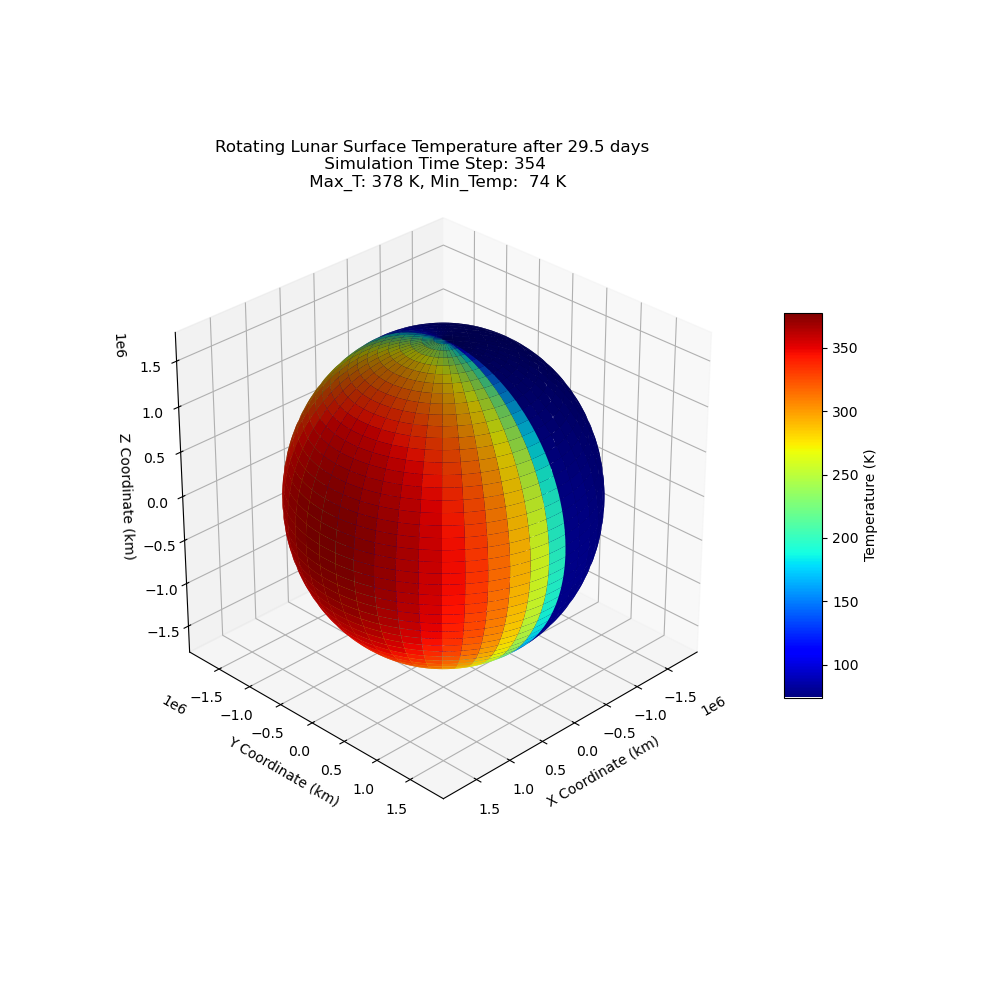

In [32]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as colors

min_temp, max_temp = heat_transfer_array.min(), heat_transfer_array.max()

deg_res = 0.5
longitude_array= np.arange(-180 + deg_res, 180,1)#, dtype = np.int16)  # setting longitude range in degrees
latitude_array = np.arange(-90 + deg_res, 90,1 )#, dtype = np.int16)  # setting latitude range in degrees, (0,90 exclusive) I'm considering the centre point of each facet
radius = moon_radius

# Convert spherical coordinates to Cartesian coordinates
lon, lat = np.meshgrid(longitude_array, latitude_array, indexing='ij')

# Convert spherical coordinates to Cartesian coordinates
x = radius * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
y = radius * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
z = radius * np.sin(np.radians(lat))

# Temperature data at surface layer (depth=0)
temp_surface = heat_transfer_array[:, :, 0]

# Normalize temperature values for color mapping
norm = colors.Normalize(vmin=np.min(temp_surface), vmax=np.max(temp_surface))
cmap = cm.jet

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_aspect(aspect = 'equal')

# Surface plot with correct color mapping
surf = ax.plot_surface(x, y, z, facecolors=cmap(norm(temp_surface)), linewidth=0, antialiased=True)

# Create a ScalarMappable for the colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])  # Empty array because plot_surface uses facecolors

# Add colorbar
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Temperature (K)')

# Labels and title
ax.set_xlabel('X Coordinate (km)')
ax.set_ylabel('Y Coordinate (km)')
ax.set_zlabel('Z Coordinate (km)')
ax.set_title(f'Rotating Lunar Surface Temperature after 29.5 days \n Simulation Time Step: {delta_t} \n Max_T: {max_temp:3.0f} K, Min_Temp: {min_temp:3.0f} K')
# ax.set_title(f'Lunar Surface Temperature at Timestep = {(timestep_to_plot) * 60} seconds')


# Adjust view angle for better visibility
ax.view_init(elev=30, azim=45)

plt.savefig(f"Lunar Surface Temperature Heatmap at Timestep = {model_run_time} seconds.png")
# 

plt.show()

In [31]:
print("temp_surface shape:", temp_surface.shape)
print("x shape:", x.shape)
print("y shape:", y.shape)
print("z shape:", z.shape)

temp_surface shape: (360, 180)
x shape: (719, 359)
y shape: (719, 359)
z shape: (719, 359)


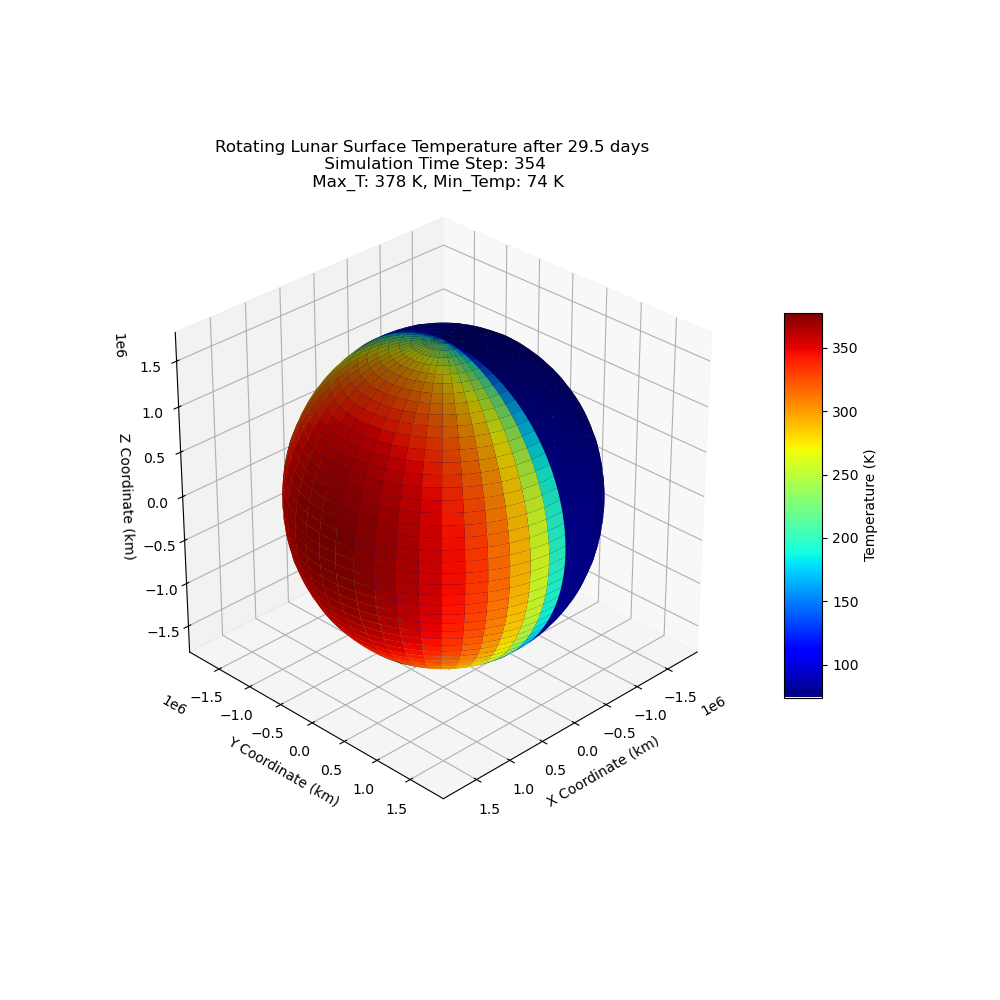

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as colors

# Define temperature range
min_temp, max_temp = heat_transfer_array.min(), heat_transfer_array.max()

deg_res = 0.5
longitude_array = np.arange(-180 + deg_res, 180, 1)  
latitude_array = np.arange(-90 + deg_res, 90, 1)  
radius = moon_radius

# Meshgrid for surface
lon, lat = np.meshgrid(longitude_array, latitude_array, indexing='ij')

# Convert spherical coordinates to Cartesian
x = radius * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
y = radius * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
z = radius * np.sin(np.radians(lat))

# Normalize temperature values for color mapping
temp_surface = heat_transfer_array[:, :, 0]
norm = colors.Normalize(vmin=min_temp, vmax=max_temp)
cmap = cm.jet

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_aspect(aspect='equal')

# Plot surface
surf = ax.plot_surface(x, y, z, facecolors=cmap(norm(temp_surface)), linewidth=0, antialiased=True)

# Add latitude and longitude lines
num_lon_lines = 12  # Adjust for more or fewer meridians
num_lat_lines = 6   # Adjust for more or fewer parallels

# Longitude lines (meridians)
for lon_val in np.linspace(-180, 180, num_lon_lines):
    lon_line = np.full_like(latitude_array, lon_val)
    x_line = radius * np.cos(np.radians(latitude_array)) * np.cos(np.radians(lon_line))
    y_line = radius * np.cos(np.radians(latitude_array)) * np.sin(np.radians(lon_line))
    z_line = radius * np.sin(np.radians(latitude_array))
    ax.plot(x_line, y_line, z_line, color='k', linewidth=0.5)

# Latitude lines (parallels)
for lat_val in np.linspace(-90, 90, num_lat_lines):
    lat_line = np.full_like(longitude_array, lat_val)
    x_line = radius * np.cos(np.radians(lat_line)) * np.cos(np.radians(longitude_array))
    y_line = radius * np.cos(np.radians(lat_line)) * np.sin(np.radians(longitude_array))
    z_line = radius * np.sin(np.radians(lat_line))
    ax.plot(x_line, y_line, z_line, color='k', linewidth=0.5)

# Create ScalarMappable for colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])  # Empty array since plot_surface uses facecolors

# Add colorbar
cbar = fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Temperature (K)')

# Labels and title
ax.set_xlabel('X Coordinate (km)')
ax.set_ylabel('Y Coordinate (km)')
ax.set_zlabel('Z Coordinate (km)')
ax.set_title(f'Rotating Lunar Surface Temperature after 29.5 days \n Simulation Time Step: {delta_t} \n Max_T: {max_temp:.0f} K, Min_Temp: {min_temp:.0f} K')

# Adjust view angle for better visibility
ax.view_init(elev=30, azim=45)

plt.show()

## The Radio Brightness Temperature

In [35]:
def radio_brightness_temp_func(alpha, T_const, heat_transfer_model_array):
    """
    Calculates the radio brightness temperature profile for lunar soil layers.

    The brightness temperature (χ) at each layer is computed recursively from bottom
    (deepest layer, near constant temperature T_const) to top (surface layer radiating into space),
    using a weighted sum of the temperatures of adjacent layers. This reflects the physical process
    of thermal emission propagating upward through the regolith.

    Formula used (from Lunar Thermal Model documentation):
        χ_n = α * χ_(n+1) + (1 - α) * T_n
    where:
        - χ is the brightness temperature at each layer.
        - α is the weighting factor determined by radio-frequency (RF) attenuation properties.
        - T_const (T*) is the constant base temperature at the deepest layer.
        - T_n is the physical temperature at layer n obtained from heat_transfer_model_array.

    Parameters:
    ----------
    alpha : float
        Weighting factor (0 < α < 1) representing RF attenuation between layers. It defines how much
        each layer’s brightness temperature is influenced by the layer immediately below it.
        A value closer to 1 implies strong dependence on deeper layers, and a smaller value
        suggests stronger influence from the immediate physical temperature of the layer.

    T_const : float
        Constant temperature (Kelvin) at the bottom-most layer of the regolith,
        assumed stable (typically ~constant below ~0.8 m depth).

    heat_transfer_array : np.ndarray
        3D numpy array of shape (latitude, longitude, depth), representing physical temperatures (Kelvin)
        at different lunar soil layers for each spatial facet. The depth axis (3rd dimension)
        is organized from surface (index 0) to the deepest layer (index -1).

    Returns:
    --------
    chi_0 : np.ndarray
        2D array of brightness temperatures (Kelvin) at the lunar surface layer (depth = 0),
        representing the radiative temperature emitted into space.

    chi_layers : np.ndarray
        3D array containing brightness temperatures (Kelvin) for all layers at each facet.
        Same shape as heat_transfer_model_array, with the depth axis ordered from surface (index 0)
        downwards.
    """

    # Step 1: Get the number of layers (depth is the last axis)
    num_layers = heat_transfer_array.shape[2]

    # Step 2: Initialize chi array for brightness temperatures
    chi_layers = np.zeros_like(heat_transfer_array)

    # Step 3: Compute brightness temperature at the bottom layer (deepest)
    chi_layers[:, :, -1] = alpha * T_const + (1 - alpha) * heat_transfer_array[:, :, -1]

    # Step 4: Recursively calculate brightness temperature upwards through layers
    for n in range(num_layers - 2, -1, -1):
        chi_layers[:, :, n] = alpha * chi_layers[:, :, n + 1] + (1 - alpha) * heat_transfer_array[:, :, n]

    # Step 5: Extract brightness temperature at the surface (top layer)
    chi_0 = chi_layers[:, :, 0]

    return chi_0, chi_layers


In [36]:
# rf_absorption_coefficent = 1
rf_absorption_coefficent = 0.5
delta_z = 0.01
alpha = np.exp(-rf_absorption_coefficent * delta_z)  # RF Transmission Coefficient
alpha

0.9950124791926823

In [37]:
chi_0 , chi_layers = radio_brightness_temp_func(alpha, T_const, heat_transfer_array)

In [38]:
chi_0.shape, chi_layers.shape

((360, 180), (360, 180, 100))

In [39]:
# chi_0[180,0], chi_layers[180,0]

## Solid Angle Calculations

In [40]:
moon_radius = 1.737e6  # Radius of the Moon in meters
distance_to_earth = 3.844e8  # Average distance from the Moon to Earth in meters

In [45]:
def calculate_solid_angles_for_moon(moon_radius, distance_to_earth, area_of_facets):
    """
    Calculates solid angles subtended by lunar facets as viewed from Earth,
    accounting for projection (cosine) effects. Only facets facing the Earth are included.

    Parameters:
    - moon_radius : float
        Radius of the Moon in meters.

    - distance_to_earth : float
        Distance from the Moon to the Earth in meters.

    - area_of_facets : np.ndarray
        2D array of lunar facet areas (m²) corresponding to latitude (0° to 90°) 
        and longitude (-180° to 180°). Shape should match the latitude-longitude grid.

    Returns:
    -------
    solid_angles : np.ndarray
        2D array (same shape as `area_of_facets`) containing solid angles in steradians.

    Notes:
    ------
    - Solid angle calculation considers both the actual facet area and its geometric projection 
      relative to Earth's viewing direction.
    - Facets not facing Earth (cos(theta) ≤ 0) will have zero solid angle.
    - Ensure the longitude ranges from -180° to 180° and latitude from 0° to 90° to 
      represent one hemisphere. (The other hemisphere can be mirrored.)

    Returns:
        solid_angles : np.ndarray
            2D array of solid angles subtended by each facet (in steradians).
    """

    # Define longitude and latitude ranges (degrees)
    deg_res = 0.5
    longitude_centres = np.arange(-180+deg_res, 180, 1)  # Longitude from -180° to 180°
    latitude_centres = np.arange(-90+deg_res, 90, 1)       # Latitude from equator to pole

    # Convert latitude and longitude arrays from degrees to radians
    latitudes_rad = np.radians(latitude_centres)
    longitudes_rad = np.radians(longitude_centres)

    # Create meshgrid for broadcasting
    lon_grid, lat_grid = np.meshgrid(longitudes_rad, latitudes_rad)

    # Facet normal vectors (in lunar-centric coordinates)
    x_facet = np.cos(lat_grid) * np.cos(lon_grid)
    y_facet = np.cos(lat_grid) * np.sin(lon_grid)
    z_facet = np.sin(lat_grid)

    facet_normals = np.stack((x_facet, y_facet, z_facet), axis=-1)

    # Vector pointing toward Earth along +x axis
    earth_vector = np.array([1, 0, 0])  # assuming Earth is directly aligned along x

    # Calculate cos(theta) between Earth and facet normals
    cos_theta = np.dot(facet_normals, earth_vector)

    # Transpose the array
    cos_theta = cos_theta.T

    # Only facets facing Earth (cos_theta > 0) contribute
    cos_theta = np.clip(cos_theta, 0, 1)

    # Calculate solid angles
    solid_angles = area_of_facets * cos_theta / (distance_to_earth**2)

    return solid_angles

In [46]:
# Calculate solid angles
solid_angles = calculate_solid_angles_for_moon(moon_radius, distance_to_earth, area_of_facets)

solid_angles[180,0]


4.736409944344394e-13

In [47]:
# Calculate solid angle for the entire visible moon
solid_angle_moon = np.sum(calculate_solid_angles_for_moon(moon_radius, distance_to_earth, area_of_facets))
solid_angle_moon

6.414794550583353e-05

## The Radio Flux Density

If Ωj is the solid angle subtended by the jth facet as viewed from the Earth, the contribution to the radio flux density is:

In [48]:
# Constants
k_B = 1.38e-23  # Boltzmann constant in J/K
wavelength = 0.21

In [49]:
def radio_flux_density(chi_0, solid_angles, wavelength):
    """
    Calculates the total radio flux density emitted by the lunar disc 
    and the flux density contribution from each individual facet.

    The radio flux density (S) at frequency ν (related to wavelength λ by c = νλ) 
    is computed from brightness temperature (χ₀) and the solid angle subtended by each facet.

    Formula:
        ΔS_j = (2 k_B χ₀_j / λ²) Ω_j

    Parameters:
    -----------
    chi_0 : np.ndarray
        2D array of brightness temperatures (Kelvin) at the lunar surface (top layer),
        shape: (latitude, longitude).
        
    solid_angles : np.ndarray
        2D array of solid angles (steradians) subtended by each lunar facet as viewed from Earth.
        Same shape as `chi_0`.
    
    wavelength : float
        Wavelength of the observed radio emission (meters).

    Returns:
    --------
    total_flux_density : float
        Total radio flux density emitted by the lunar disc (Watts per square meter per Hertz, W·m⁻²·Hz⁻¹).
        
    delta_S : np.ndarray
        2D array of the flux density contribution from each individual facet (W/m²/Hz).
        Same shape as `chi_0`.

    Notes:
    ------
    - Boltzmann's constant (k_B ≈ 1.380649 × 10⁻²³ J/K) relates brightness temperature to radiative flux.
    - Radio flux density per facet follows the Rayleigh-Jeans approximation:

      Delta S = 2 * k_B * chi_0 * Omega/lambda^2

    Reference:
    ----------
    - Radio astronomy fundamentals: [https://science.nrao.edu/opportunities/courses/era/flux-density](https://science.nrao.edu/opportunities/courses/ERA/radioastronomybasics.pdf)
    """
    # Individual flux density contribution (W/m²/Hz)
    delta_S = (2 * k_B * chi_0 * solid_angles) / (wavelength**2)

    # Total flux density (W/m²/Hz)
    total_flux_density = np.sum(delta_S)

    return total_flux_density, delta_S


In [50]:
total_flux_density_arr, delta_S = radio_flux_density(chi_0, solid_angles, wavelength)

In [51]:
total_flux_density_arr

9.05419688431299e-24

In [52]:
def average_radio_brightness_temperature(total_flux_density, wavelength, solid_angle_moon):
    """
    Calculates the average radio brightness temperature (Kelvin) for the lunar disc 
    based on the total measured radio flux density.

    The average brightness temperature (T_b) provides a single representative temperature
    value derived from the total flux density and the Moon's apparent solid angle in the sky.

    Parameters:
    -----------
    total_flux_density : float
        The total radio flux density emitted by the lunar disc (W/m²/Hz).

    wavelength : float
        Wavelength of the observed radio emission (meters).

    solid_angle_moon : float
        Total solid angle (steradians) subtended by the lunar disc as seen from Earth.
        Typically Ω₀ ≈ 6.4236 × 10⁻⁵ sr at mean Earth-Moon distance (~384,400 km).

    Returns:
    --------
    average_brightness_temp : float
        Average brightness temperature (Kelvin) of the lunar disc.

    Formula:
    --------
    T_b = S lambda^2/{2 k_B Omega_0

    where:
    - S is the total flux density (W·m⁻²·Hz⁻¹),
    - λ is the wavelength (m),
    - k_B ≈ 1.380649 × 10⁻²³ J/K is Boltzmann's constant,
    - Ω₀ is the solid angle subtended by the Moon (steradians).

    Reference:
    ----------
    - NRAO Radio Astronomy Basics: [Link](https://science.nrao.edu/opportunities/courses/ERA/radioastronomybasics.pdf)
    """
    
    # Calculate average brightness temperature (Kelvin)
    average_brightness_temp = (total_flux_density * wavelength**2) / (2 * k_B * solid_angle_moon)

    return average_brightness_temp

In [53]:
avg_brightness_temperature_arr = average_radio_brightness_temperature(total_flux_density_arr, wavelength, solid_angle_moon)
avg_brightness_temperature_arr

225.52603772602725

### Kens moon_temp_model